In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
a= np.ones(3)
np.random.choice(np.flatnonzero(a == a.max()))

0

In [4]:
def make_epsilon_greedy_policy(epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """  
    def policy_fn(Q,state):
        # Implement this!
        actions_at_St = Q[state]
        probs = np.ones(actions_at_St.size, dtype=float) * epsilon / actions_at_St.size
        best_action = np.random.choice(np.flatnonzero(actions_at_St == actions_at_St.max()))#break tie randomly
        probs[best_action] += (1.0 - epsilon)
        action = np.random.choice(np.arange(len(probs)), p=probs)#choose an action base on their probs
        return action
    
    return policy_fn

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
 
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(epsilon, env.action_space.n)
    
    # Implement this!
    for n in range(num_episodes):
        if (n+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(n+1, num_episodes), end="")
            sys.stdout.flush()        
            
        obs = env.reset()
        G = 0.0
        episode_rewards = []
        episode_states = []
        episode_actions = []
        while True:#sample from env untill this episode finish
            episode_states.insert(0,obs)
            action = policy(Q,obs)
            episode_actions.insert(0,action)
            obs,reward,done,_ = env.step(action)
            episode_rewards.insert(0,reward)
            if done:
                break

        #see page 123 in RL book for more details
        for idx,(state,action,reward) in enumerate(zip(episode_states,episode_actions,episode_rewards)):
            G = discount_factor*G +reward
            past_states = episode_states[idx+1:]
            past_actions = episode_actions[idx+1:]
            if state not in past_states or action not in past_actions:
                returns_sum[state] += G
                returns_count[state] += 1.0
                Q[state][action] = returns_sum[state]/returns_count[state]
    
    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

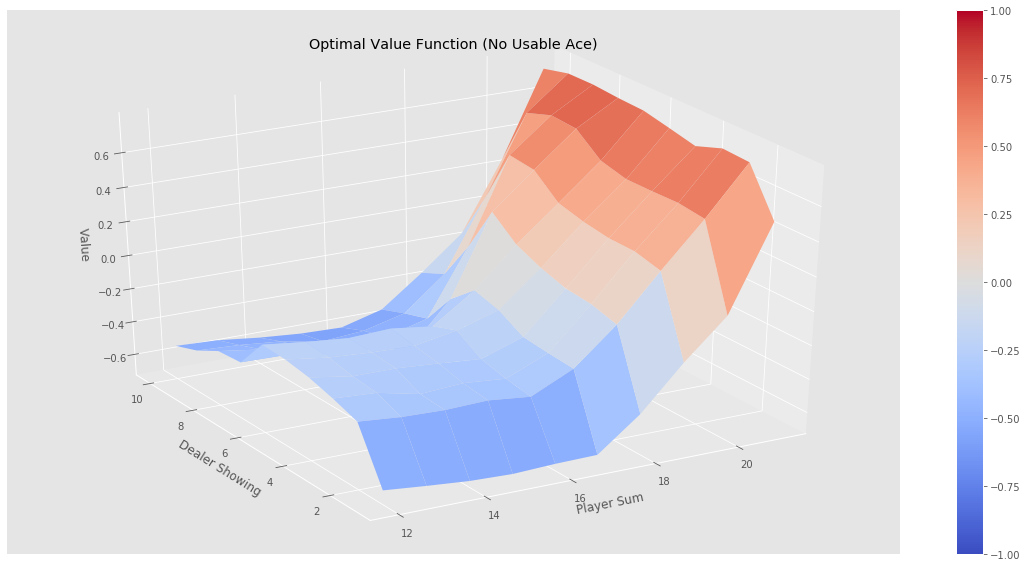

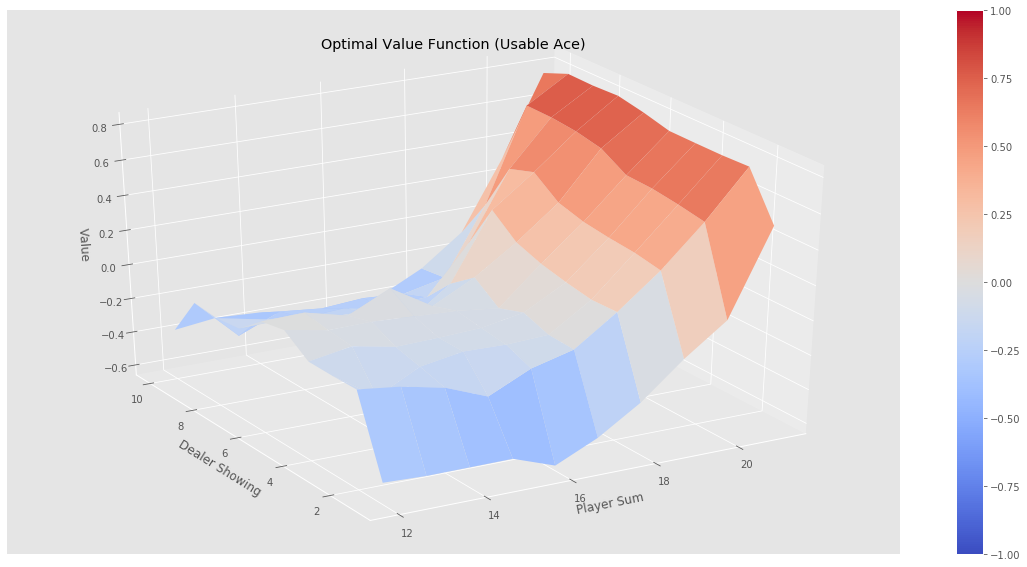

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")